# Preparation and testing of model specification

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from pathlib import Path
from time import time

import aesara
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from matplotlib.lines import Line2D

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/docs/design_notes/omnistaging.md.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.


In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import DataFile, data_path
from speclet.loggers import set_console_handler_level
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Logging.
set_console_handler_level("DEBUG")
aesara.config.exception_verbosity = "high"

# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
SEED = 847
np.random.seed(SEED)
arviz_config()

## Data

In [5]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df.query("screen == 'broad'").reset_index(drop=True)

In [6]:
crispr_data_manager = CrisprScreenDataManager(
    DataFile.DEPMAP_CRC_SUBSAMPLE, transformations=[_broad_only]
)
crc_data = crispr_data_manager.get_data()

In [7]:
for col in ["sgrna", "hugo_symbol", "depmap_id"]:
    print(f"'{col}': {crc_data[col].nunique()}")

'sgrna': 162
'hugo_symbol': 103
'depmap_id': 8


## Distributions

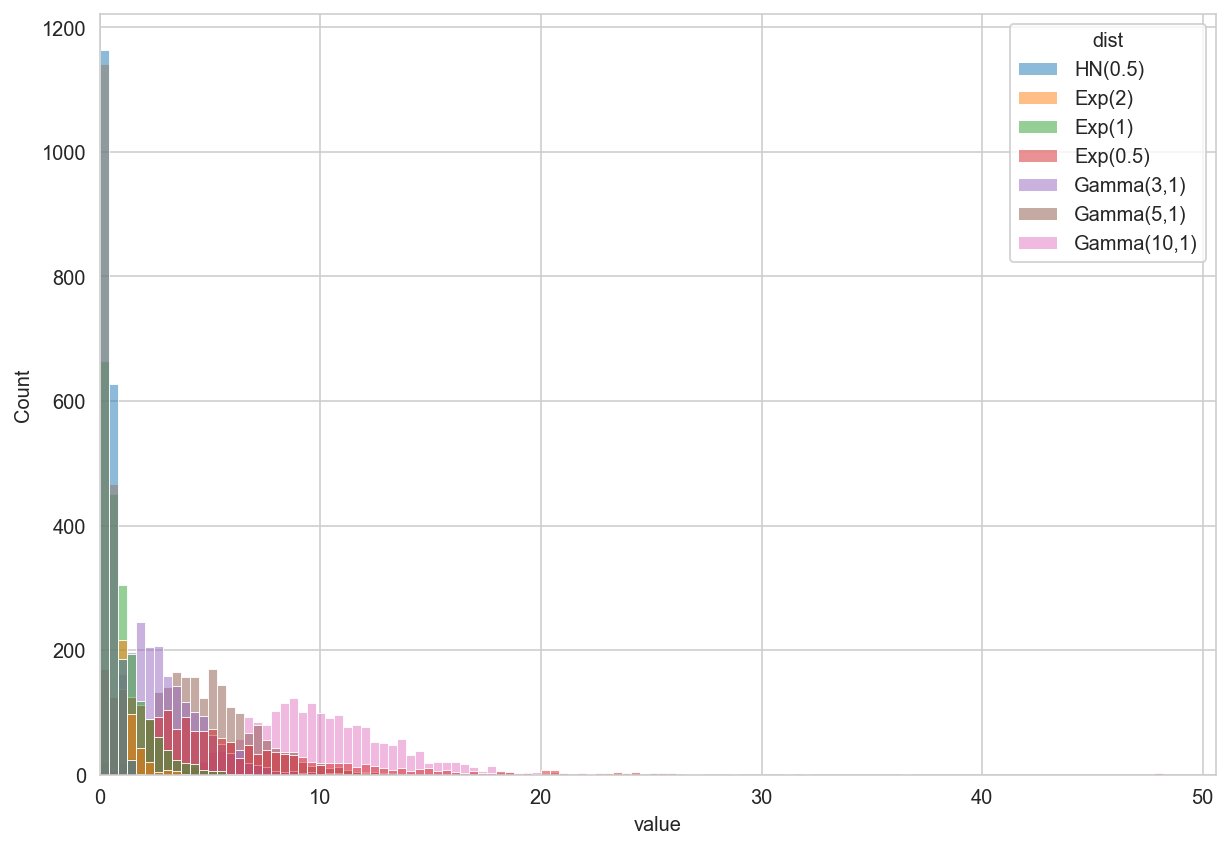

In [8]:
N = 2000
df = pd.DataFrame()
df = pd.concat(
    [
        df,
        pd.DataFrame({"value": pm.draw(pm.HalfNormal.dist(0.5), N), "dist": "HN(0.5)"}),
        pd.DataFrame({"value": pm.draw(pm.Exponential.dist(2), N), "dist": "Exp(2)"}),
        pd.DataFrame({"value": pm.draw(pm.Exponential.dist(1), N), "dist": "Exp(1)"}),
        pd.DataFrame(
            {"value": pm.draw(pm.Exponential.dist(0.2), N), "dist": "Exp(0.5)"}
        ),
        pd.DataFrame({"value": pm.draw(pm.Gamma.dist(3, 1), N), "dist": "Gamma(3,1)"}),
        pd.DataFrame({"value": pm.draw(pm.Gamma.dist(5, 1), N), "dist": "Gamma(5,1)"}),
        pd.DataFrame(
            {"value": pm.draw(pm.Gamma.dist(10, 1), N), "dist": "Gamma(10,1)"}
        ),
    ]
).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=df, x="value", hue="dist", ax=ax)
ax.set_xlim(0, None)
plt.show()

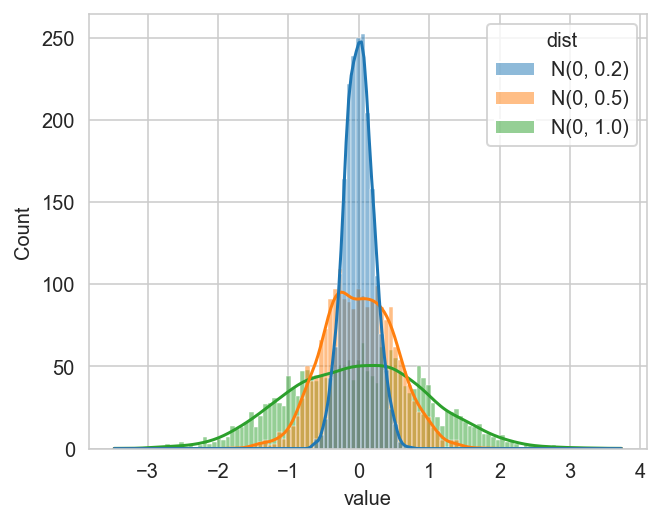

In [9]:
N = 2000
df = pd.concat(
    [
        pd.DataFrame(
            {"value": pm.draw(pm.Normal.dist(0, 0.2), N), "dist": "N(0, 0.2)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.Normal.dist(0, 0.5), N), "dist": "N(0, 0.5)"}
        ),
        pd.DataFrame({"value": pm.draw(pm.Normal.dist(0, 1), N), "dist": "N(0, 1.0)"}),
    ]
).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(data=df, x="value", hue="dist", ax=ax, kde=True)
plt.show()

In [10]:
df.groupby("dist").describe()

value                                                              \
            count      mean       std       min       25%       50%       75%   
dist                                                                            
N(0, 0.2)  2000.0 -0.000459  0.205834 -0.626704 -0.143254 -0.001944  0.133784   
N(0, 0.5)  2000.0  0.002351  0.504981 -1.790798 -0.356570  0.002581  0.358139   
N(0, 1.0)  2000.0 -0.007928  0.973466 -3.474540 -0.705628  0.003896  0.646462   

                     
                max  
dist                 
N(0, 0.2)  0.735502  
N(0, 0.5)  1.780401  
N(0, 1.0)  3.729271

(0.0, 86.1)

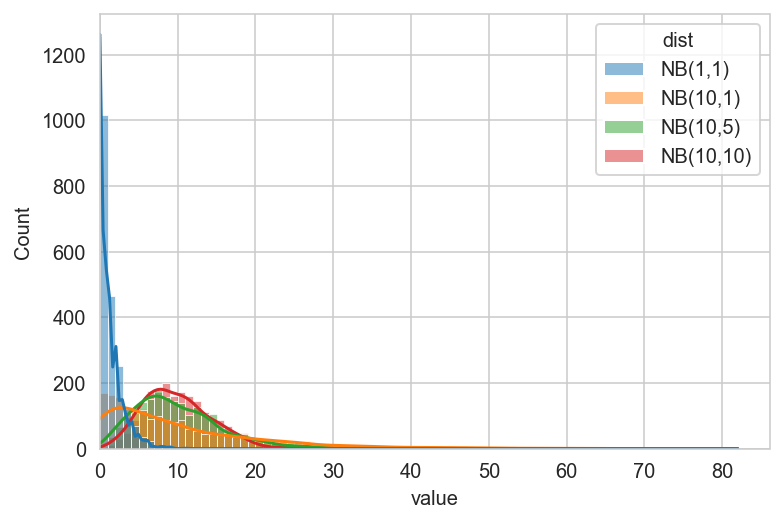

In [11]:
N = 2000
df = pd.DataFrame()
df = pd.concat(
    [
        df,
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(1, 1), N), "dist": "NB(1,1)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(10, 1), N), "dist": "NB(10,1)"}
        ),
        pd.DataFrame(
            {"value": pm.draw(pm.NegativeBinomial.dist(10, 5), N), "dist": "NB(10,5)"}
        ),
        pd.DataFrame(
            {
                "value": pm.draw(pm.NegativeBinomial.dist(10, 10), N),
                "dist": "NB(10,10)",
            }
        ),
    ]
)
df = df.reset_index(drop=True)
ax = sns.histplot(data=df, x="value", hue="dist", kde=True, binwidth=1)
ax.set_xlim(0, None)

## Modeling

In [20]:
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel

In [14]:
crc_model = LineageHierNegBinomModel(lineage="colorectal")
valid_crc_data = crc_model.data_processing_pipeline(crc_data.copy())

[07/25/22 15:28:44] INFO     Processing data for modeling.     ]8;id=500319;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=332533;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#267\267]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=294824;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=868559;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#268\268]8;;\

[07/25/22 15:28:45] WARNING  number of data points dropped: 0  ]8;id=296279;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=745286;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#319\319]8;;\

                    INFO     Processing data for modeling.     ]8;id=275140;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=478736;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#267\267]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=395603;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=517085;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#268\268]8;;\

[07/25/22 15:28:46] WARNING  number of data points dropped: 0  ]8;id=299603;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=880693;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#319\319]8;;\

                    INFO     number of genes mutated in all    ]8;id=560051;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=16731;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#439\439]8;;\
                             cells lines: 1                                                  

                    DEBUG    Genes always mutated: APC         ]8;id=90306;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=456368;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#442\442]8;;\

                    INFO     Dropping 2 cancer genes.          ]8;id=408975;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=385311;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#495\495]8;;\

                    DEBUG    Dropped cancer genes: ['APC',     ]8;id=987958;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=984549;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#496\496]8;;\
                             'MDM2']                                                         

                    INFO     Lineage: colorectal               ]8;id=560695;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=820468;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#323\323]8;;\

                    INFO     Number of genes: 103              ]8;id=319547;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=858081;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#324\324]8;;\

                    INFO     Number of sgRNA: 162              ]8;id=806172;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=753148;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#325\325]8;;\

                    INFO     Number of cell lines: 8           ]8;id=898978;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=959587;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#326\326]8;;\

                    INFO     Number of cancer genes: 3         ]8;id=558483;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=783385;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#327\327]8;;\

                    INFO     Number of screens: 1              ]8;id=967532;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=421955;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#328\328]8;;\

                    INFO     Number of data points: 1296       ]8;id=98895;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=760036;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#329\329]8;;\

                    DEBUG    shape of cancer gene matrix:      ]8;id=27734;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=225418;file:///Users/admin/Developer/haigis-lab/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#364\364]8;;\
                             (1296, 3)                                                       

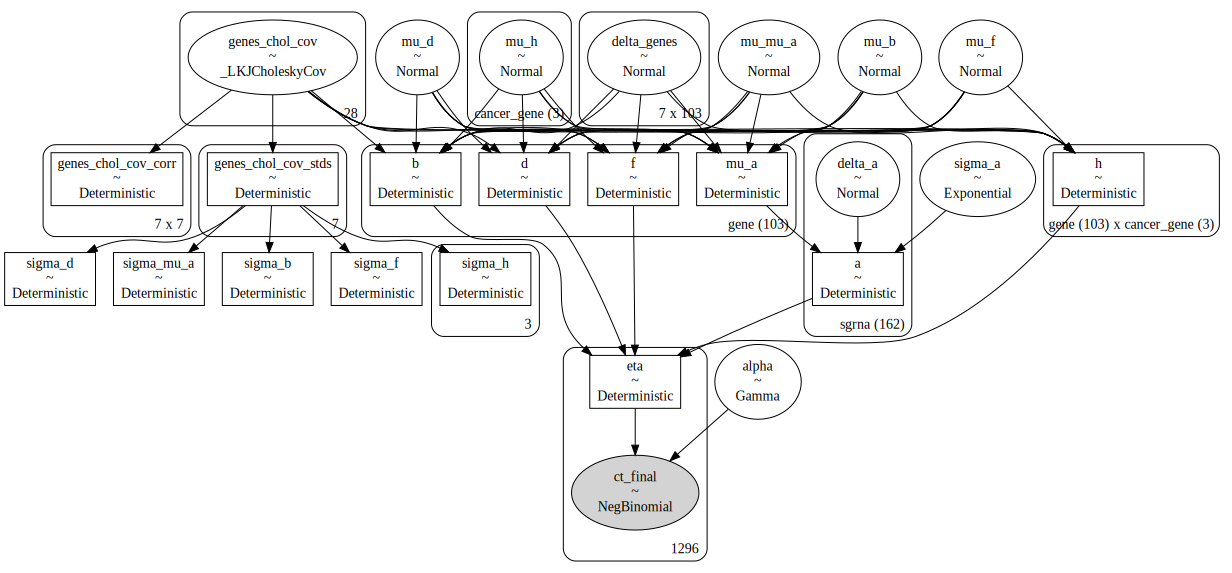

In [15]:
crc_pymc_model = crc_model.pymc_model(crispr_data_manager.data.copy())
pm.model_to_graphviz(crc_pymc_model)

In [21]:
with crc_pymc_model:
    pm_prior_pred = pm.sample_prior_predictive(
        var_names=["eta", "ct_final", "mu_a"], random_seed=SEED
    )

print("prior predictive distribution")
pm_pred_draws = pm_prior_pred.prior_predictive["ct_final"].values.squeeze()
for q in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1]:
    res = np.quantile(pm_pred_draws, q=q)
    print(f"  {int(q*100)}%: {int(res):0,d}")

print("")
obs = valid_crc_data["counts_final"].astype(int)
print(f"final counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

obs = valid_crc_data["counts_initial_adj"].astype(int)
print(f"initial counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

prior predictive distribution
  0%: 0
  1%: 2
  10%: 41
  20%: 99
  30%: 175
  40%: 281
  50%: 434
  60%: 670
  70%: 1,073
  80%: 1,886
  90%: 4,473
  99%: 71,602
  100%: 2,806,501,886,619

final counts
  min: 0,  max: 9,819
initial counts
  min: 57,  max: 4,741


In [17]:
a = np.ones((4))
b = np.ones((3))
np.hstack([a, b])

array([1., 1., 1., 1., 1., 1., 1.])

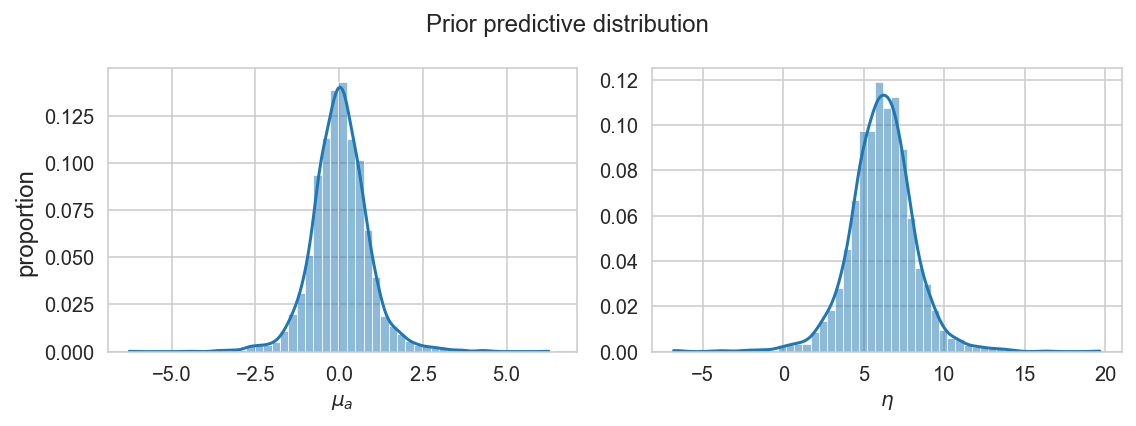

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
eta_prior = np.random.choice(pm_prior_pred.prior["eta"].values.flatten(), 2000)
mu_prior = np.random.choice(pm_prior_pred.prior["mu_a"].values.flatten(), 4000)
sns.histplot(mu_prior, kde=True, ax=axes[0], binwidth=0.25, stat="proportion")
sns.histplot(eta_prior, kde=True, ax=axes[1], binwidth=0.5, stat="proportion")
axes[0].set_xlabel(r"$\mu_a$")
axes[1].set_xlabel(r"$\eta$")
for ax in axes.flatten():
    ax.set_ylabel(None)
    ax.set_title(None)

fig.supylabel("proportion")
fig.suptitle("Prior predictive distribution")
fig.tight_layout()
plt.show()

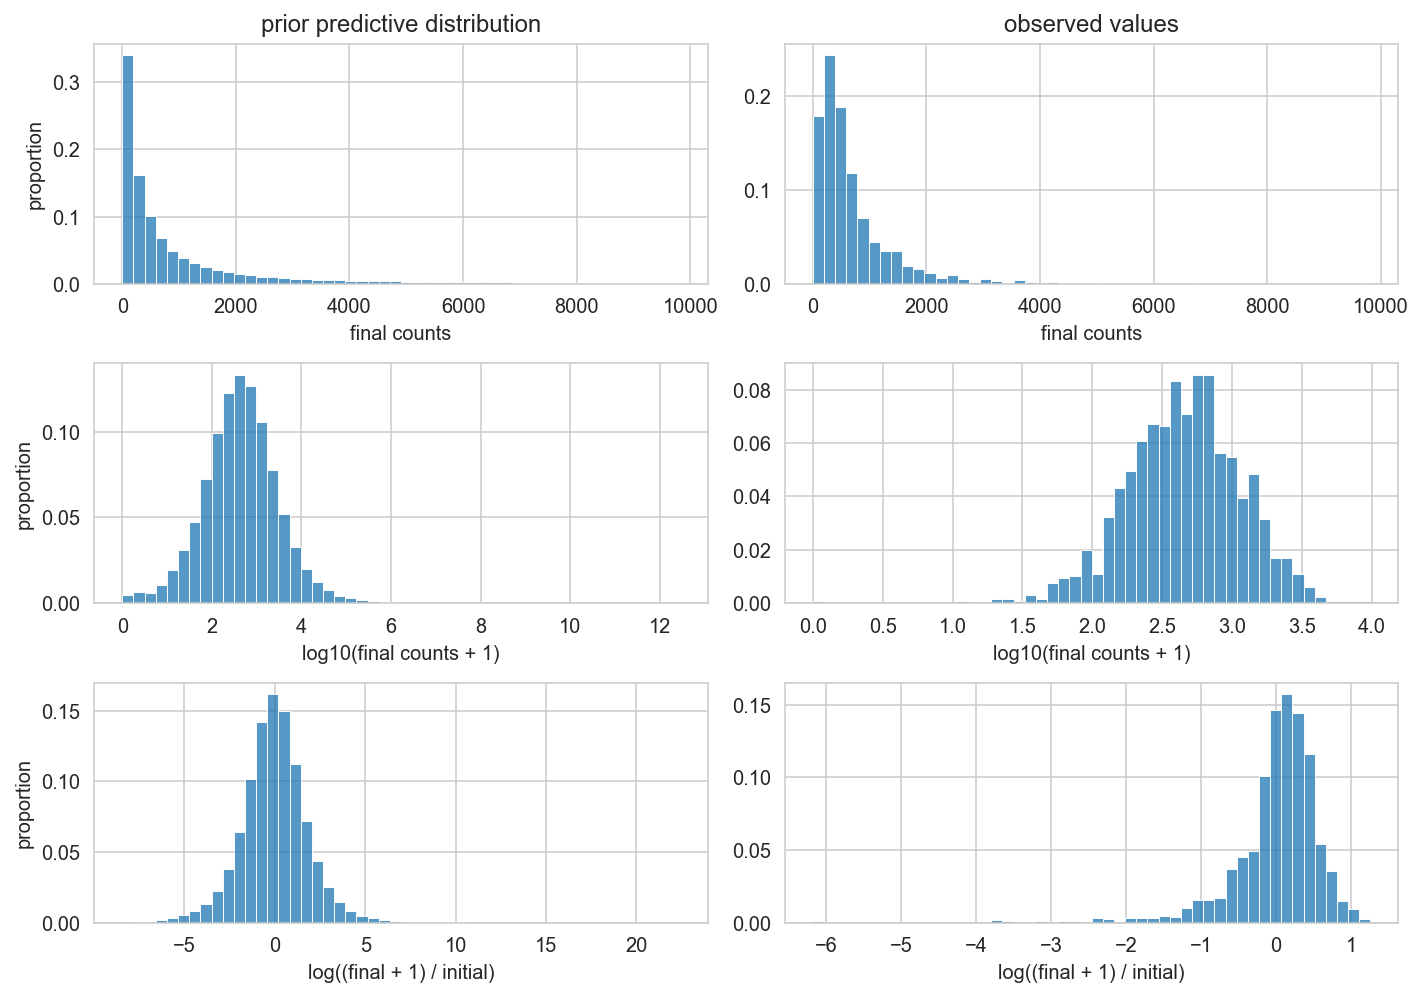

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7))

stat = "proportion"

obs_max = crc_data["counts_final"].max()
truncated_prior_preds = [x for x in pm_pred_draws.flatten() if x <= obs_max]

# Untransformed
sns.histplot(x=truncated_prior_preds, ax=axes[0, 0], bins=50, stat=stat)
sns.histplot(x=valid_crc_data["counts_final"], ax=axes[0, 1], bins=50, stat=stat)
# Log10 transformed
sns.histplot(x=np.log10(pm_pred_draws.flatten() + 1), ax=axes[1, 0], bins=50, stat=stat)
sns.histplot(
    x=np.log10(valid_crc_data["counts_final"] + 1), ax=axes[1, 1], bins=50, stat=stat
)
# Log-fold change
pp_lfc = np.log(
    (pm_pred_draws + 1) / (valid_crc_data["counts_initial_adj"].values[None, :])
)
obs_lfc = np.log(
    (valid_crc_data["counts_final"] + 1) / valid_crc_data["counts_initial_adj"]
)
sns.histplot(x=pp_lfc.flatten(), ax=axes[2, 0], bins=50, stat=stat)
sns.histplot(x=obs_lfc, ax=axes[2, 1], bins=50, stat=stat)


axes[0, 0].set_title("prior predictive distribution")
axes[0, 1].set_title("observed values")

for ax in axes[0, :]:
    ax.set_xlabel("final counts")

for ax in axes[1, :]:
    ax.set_xlabel("log10(final counts + 1)")

for ax in axes[2, :]:
    ax.set_xlabel("log((final + 1) / initial)")

for ax in axes[:, 0]:
    ax.set_ylabel(stat)
for ax in axes[:, 1]:
    ax.set_ylabel(None)

plt.tight_layout()
plt.show()

## Sampling

In [23]:
with crc_pymc_model:
    trace = pymc.sampling_jax.sample_numpyro_nuts(
        draws=1000,
        tune=1000,
        target_accept=0.92,
        random_seed=SEED,
        idata_kwargs={"log_likelihood": False},
    )
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=SEED)

Compiling...
Compilation time =  0:00:10.915332
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:04:12.718245
Transforming variables...
Transformation time =  0:00:04.213203


## Posterior analysis

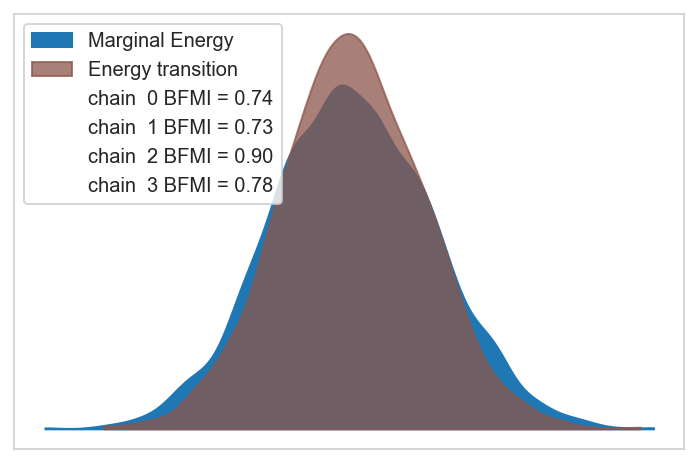

In [24]:
az.plot_energy(trace);

In [25]:
trace.sample_stats.diverging.values.sum(axis=1)

array([0, 0, 0, 0])

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/arviz/utils.py:136: UserWarning: Items starting with ~: ['^mu$', '.*effect$', '^celllines_chol_cov.*$', '^.*celllines$'] have not been found and will be ignored


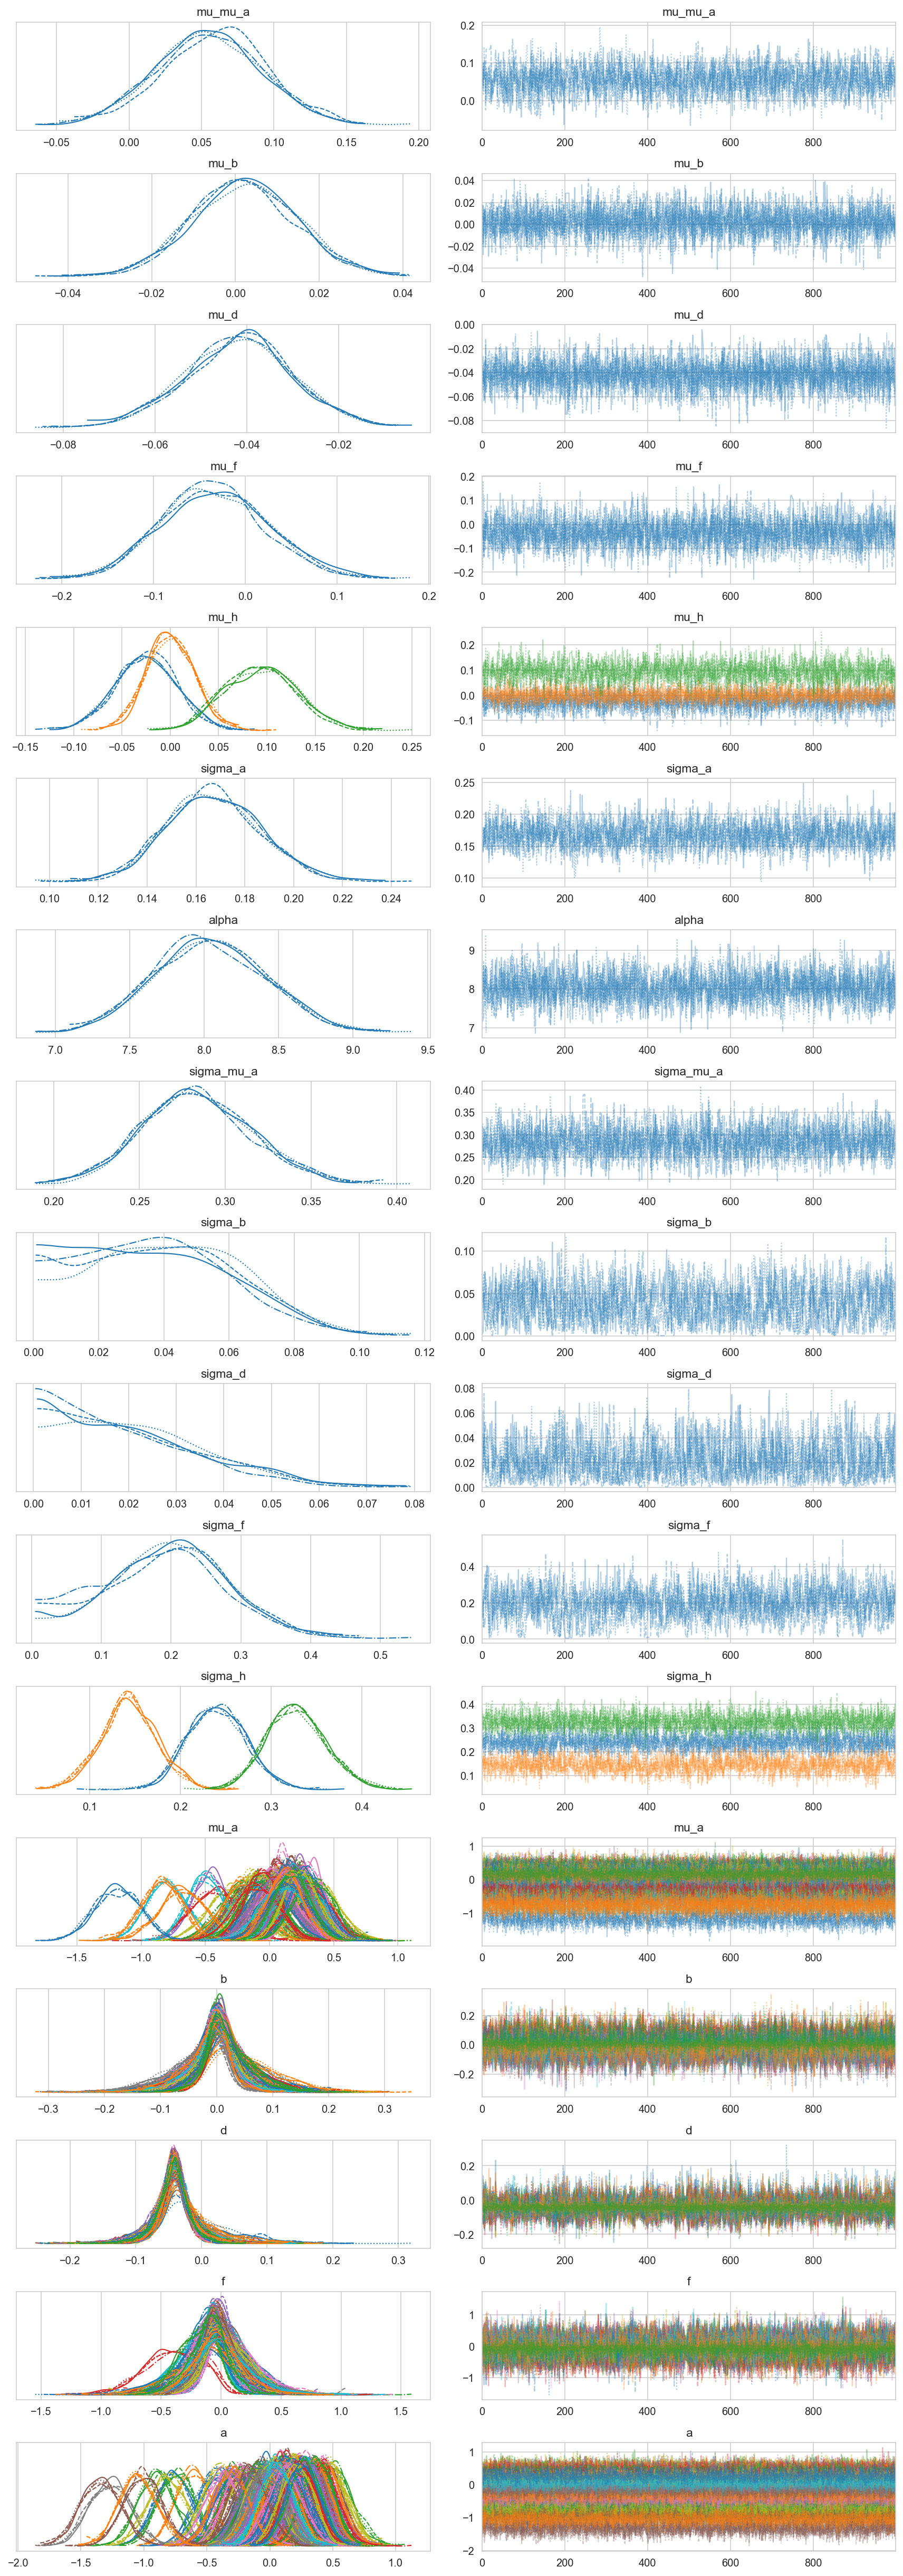

In [38]:
az.plot_trace(trace, var_names=crc_model.vars_regex() + ["~^h$"], filter_vars="regex")
plt.tight_layout();

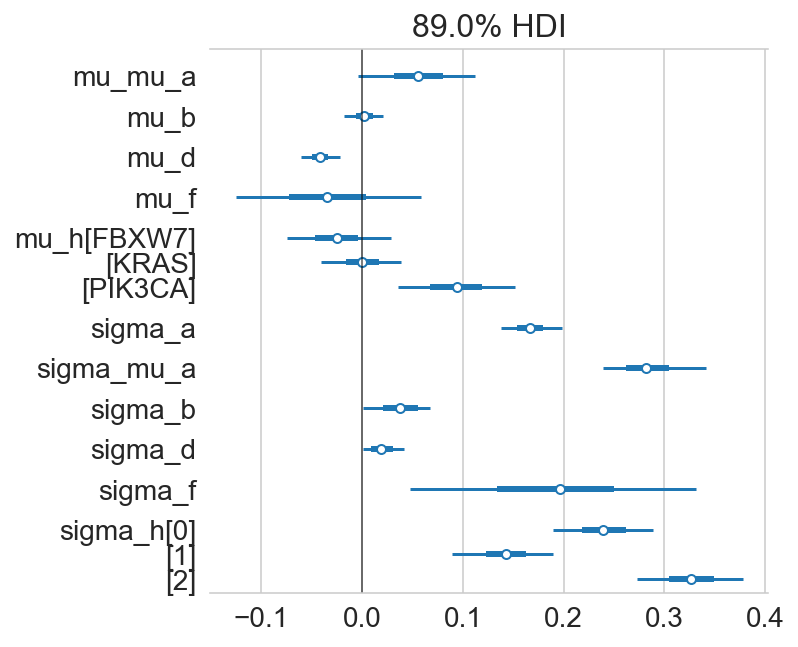

In [27]:
ax = az.plot_forest(
    trace,
    var_names=["mu_mu_a", "mu_b", "mu_d", "mu_f", "mu_h", "^sigma.*$"],
    filter_vars="regex",
    combined=True,
    figsize=(5, 5),
)
ax[0].axvline(color="k", alpha=0.5, linewidth=1)
plt.show()

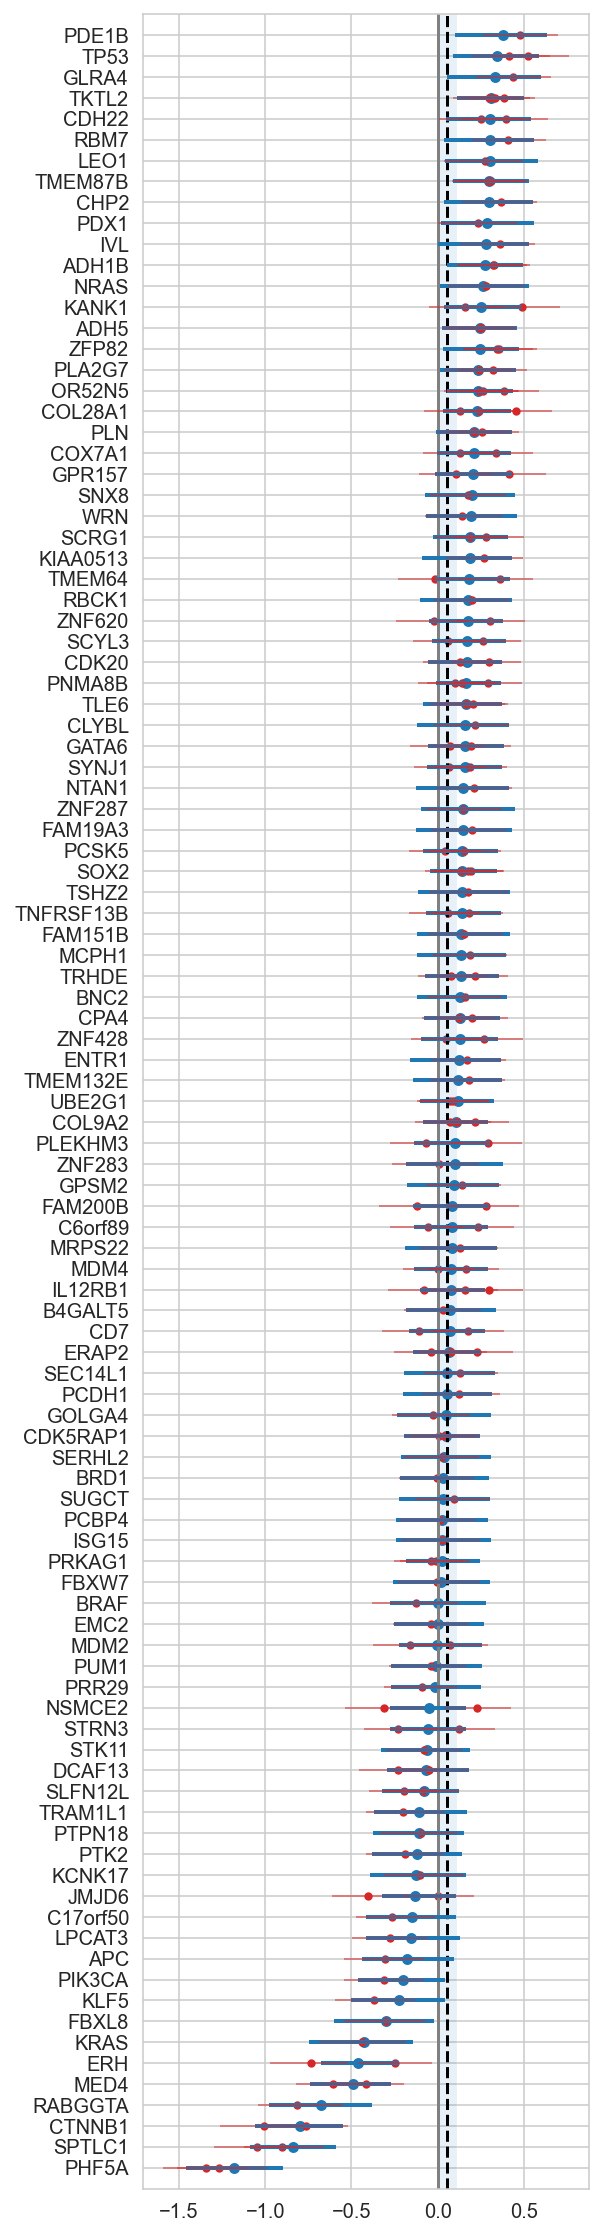

In [28]:
gene_order = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .sort_values("mean")["hugo_symbol"]
    .tolist()
)

sgrna_to_gene_map = (
    crc_data[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)
a_post = (
    az.summary(trace, var_names=["a"], kind="stats")
    .pipe(extract_coords_param_names, names=["sgrna"])
    .reset_index(drop=True)
    .merge(sgrna_to_gene_map, on="sgrna", validate="one_to_one")
)
mu_a_post = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .reset_index(drop=True)
)

a_post["hugo_symbol"] = pd.Categorical(
    a_post["hugo_symbol"], categories=gene_order, ordered=True
)
a_post = a_post.sort_values("hugo_symbol").reset_index(drop=True)
mu_a_post["hugo_symbol"] = pd.Categorical(
    mu_a_post["hugo_symbol"], categories=gene_order, ordered=True
)
mu_a_post = mu_a_post.sort_values("hugo_symbol").reset_index(drop=True)

mu_mu_a_post = az.summary(trace, var_names=["mu_mu_a"], kind="stats")
assert len(mu_mu_a_post) == 1
mu_mu_a_avg = mu_mu_a_post["mean"][0]
mu_mu_a_hdi = (mu_mu_a_post["hdi_5.5%"][0], mu_mu_a_post["hdi_94.5%"][0])

fig, ax = plt.subplots(figsize=(4, 20))
plt.axvline(0, color="grey")

# Population average and HDI
plt.fill_between(x=mu_mu_a_hdi, y1=-1, y2=len(mu_a_post), alpha=0.1)
plt.axvline(mu_mu_a_avg, color="k", linestyle="--")

# Gene estimates.
plt.hlines(
    y=mu_a_post["hugo_symbol"],
    xmin=mu_a_post["hdi_5.5%"],
    xmax=mu_a_post["hdi_94.5%"],
    color="tab:blue",
    linewidth=2,
)
plt.scatter(x=mu_a_post["mean"], y=mu_a_post["hugo_symbol"], s=20, c="tab:blue")

# sgRNA estimates.
plt.hlines(
    y=a_post["hugo_symbol"],
    xmin=a_post["hdi_5.5%"],
    xmax=a_post["hdi_94.5%"],
    color="tab:red",
    linewidth=1,
    alpha=0.5,
)
plt.scatter(x=a_post["mean"], y=a_post["hugo_symbol"], s=10, c="tab:red")

plt.ylim(-1, len(mu_a_post))
plt.show()

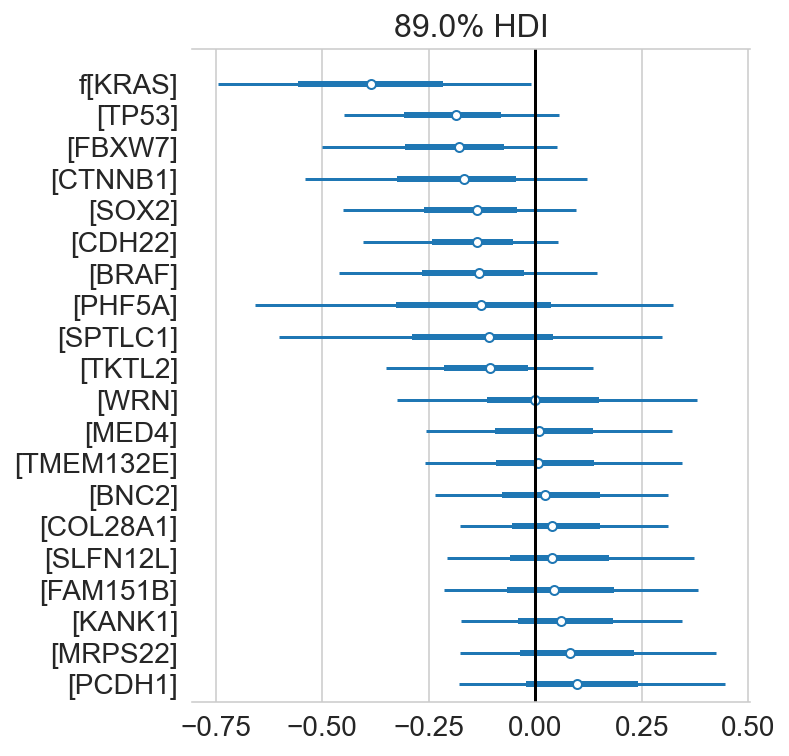

In [29]:
top_mut_effect_genes = (
    az.summary(trace, var_names=["f"])
    .sort_values("mean")
    .pipe(head_tail)
    .pipe(extract_coords_param_names, "hugo_symbol")["hugo_symbol"]
    .tolist()
)
ax = az.plot_forest(
    trace,
    var_names=["f"],
    coords={"gene": top_mut_effect_genes},
    combined=True,
    figsize=(5, 6),
)
ax[0].axvline(0, color="k")
plt.show()

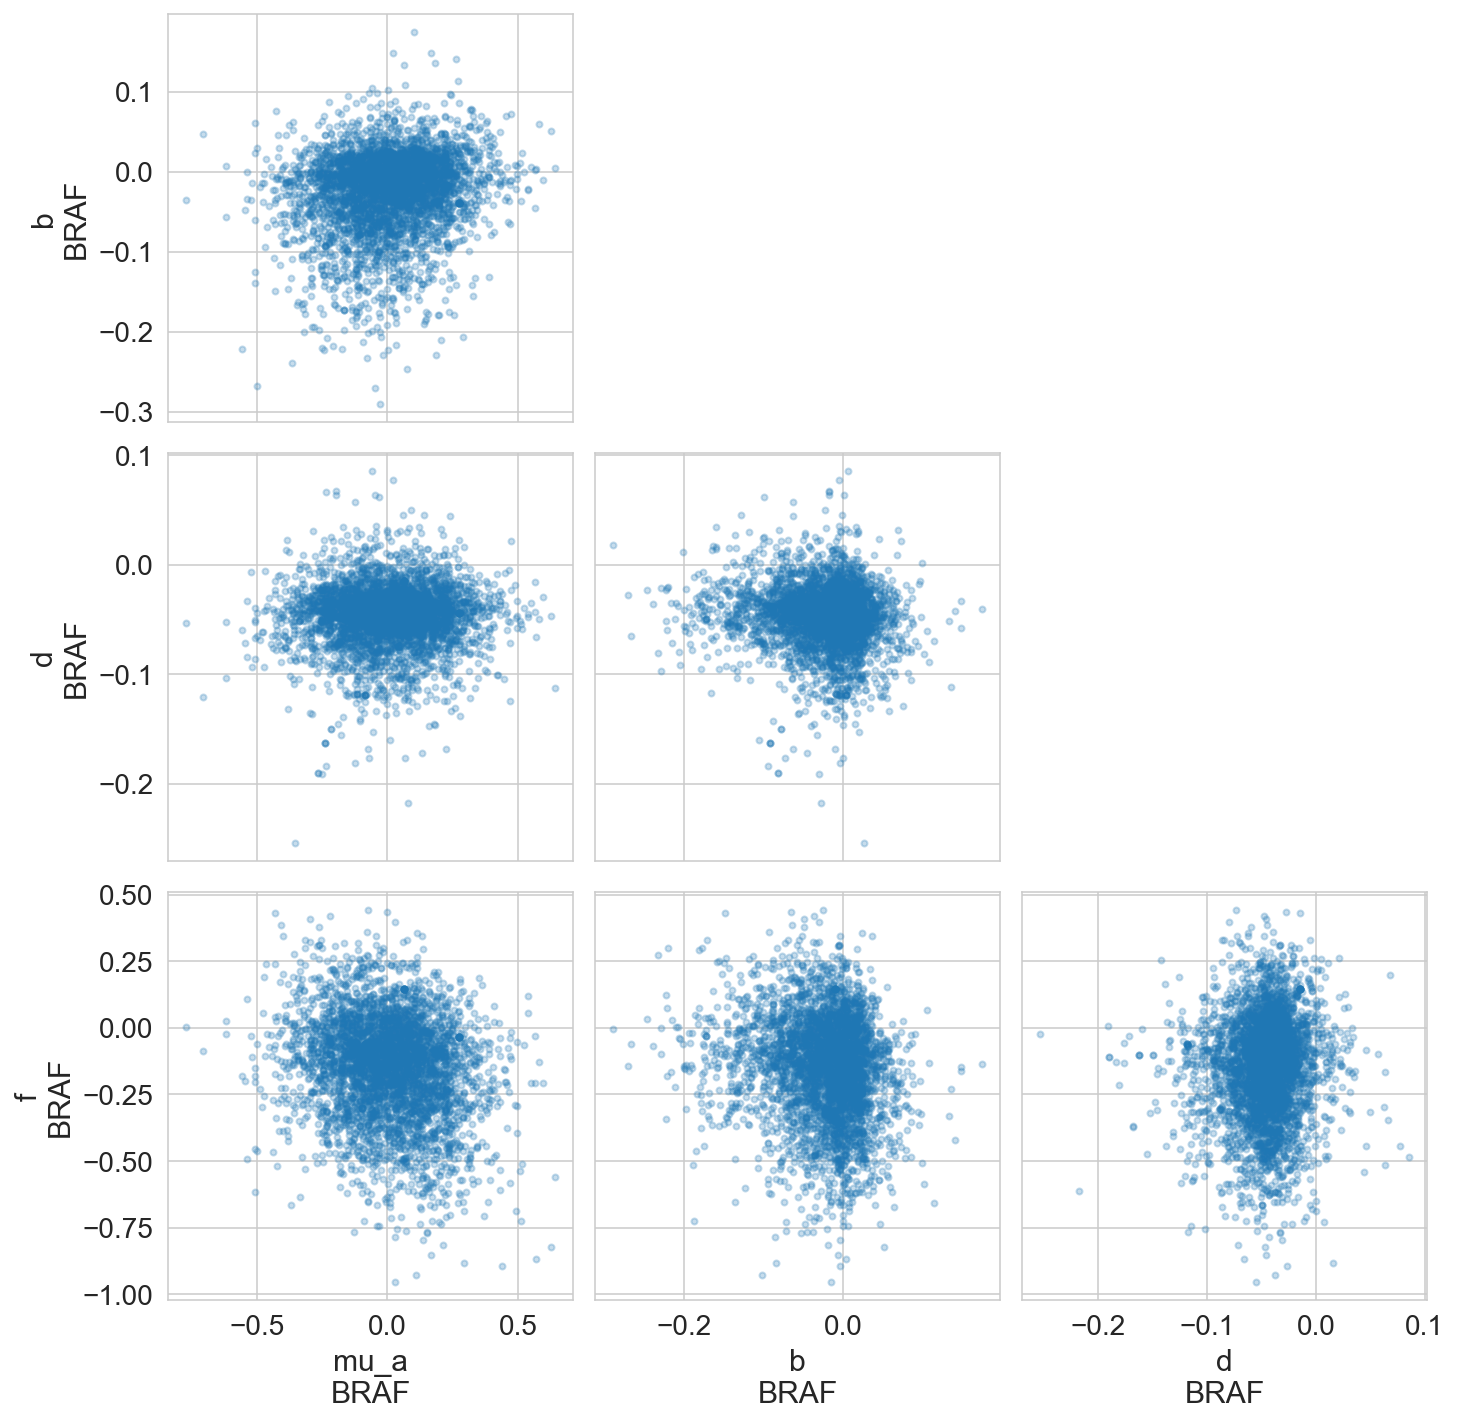

In [30]:
az.plot_pair(
    trace,
    var_names=["mu_a", "b", "d", "f"],
    coords={"gene": ["BRAF"]},
    scatter_kwargs={"alpha": 0.25},
    figsize=(10, 10),
)
plt.tight_layout()
plt.show()

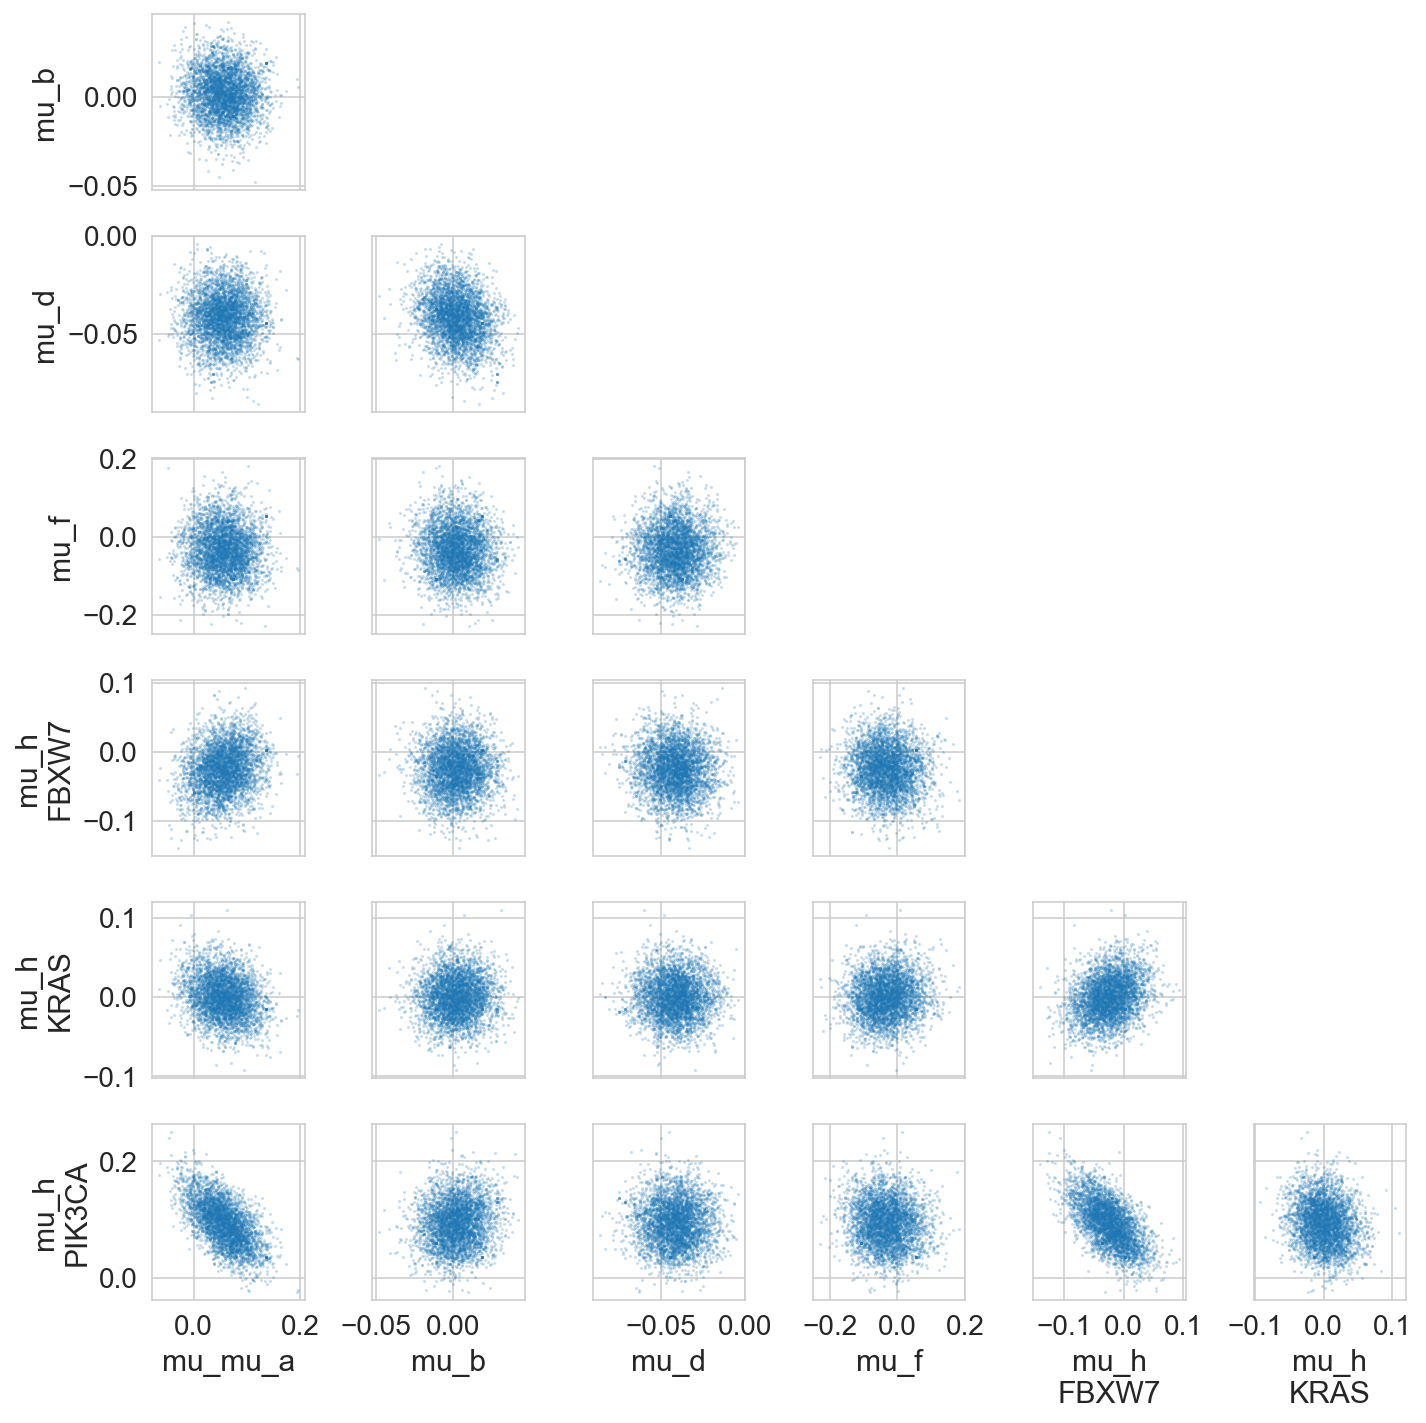

In [31]:
az.plot_pair(
    trace,
    var_names=["mu_mu_a", "mu_b", "mu_d", "mu_f", "mu_h"],
    scatter_kwargs={"alpha": 0.25, "markersize": 1},
    figsize=(10, 10),
)
plt.tight_layout()
plt.show()

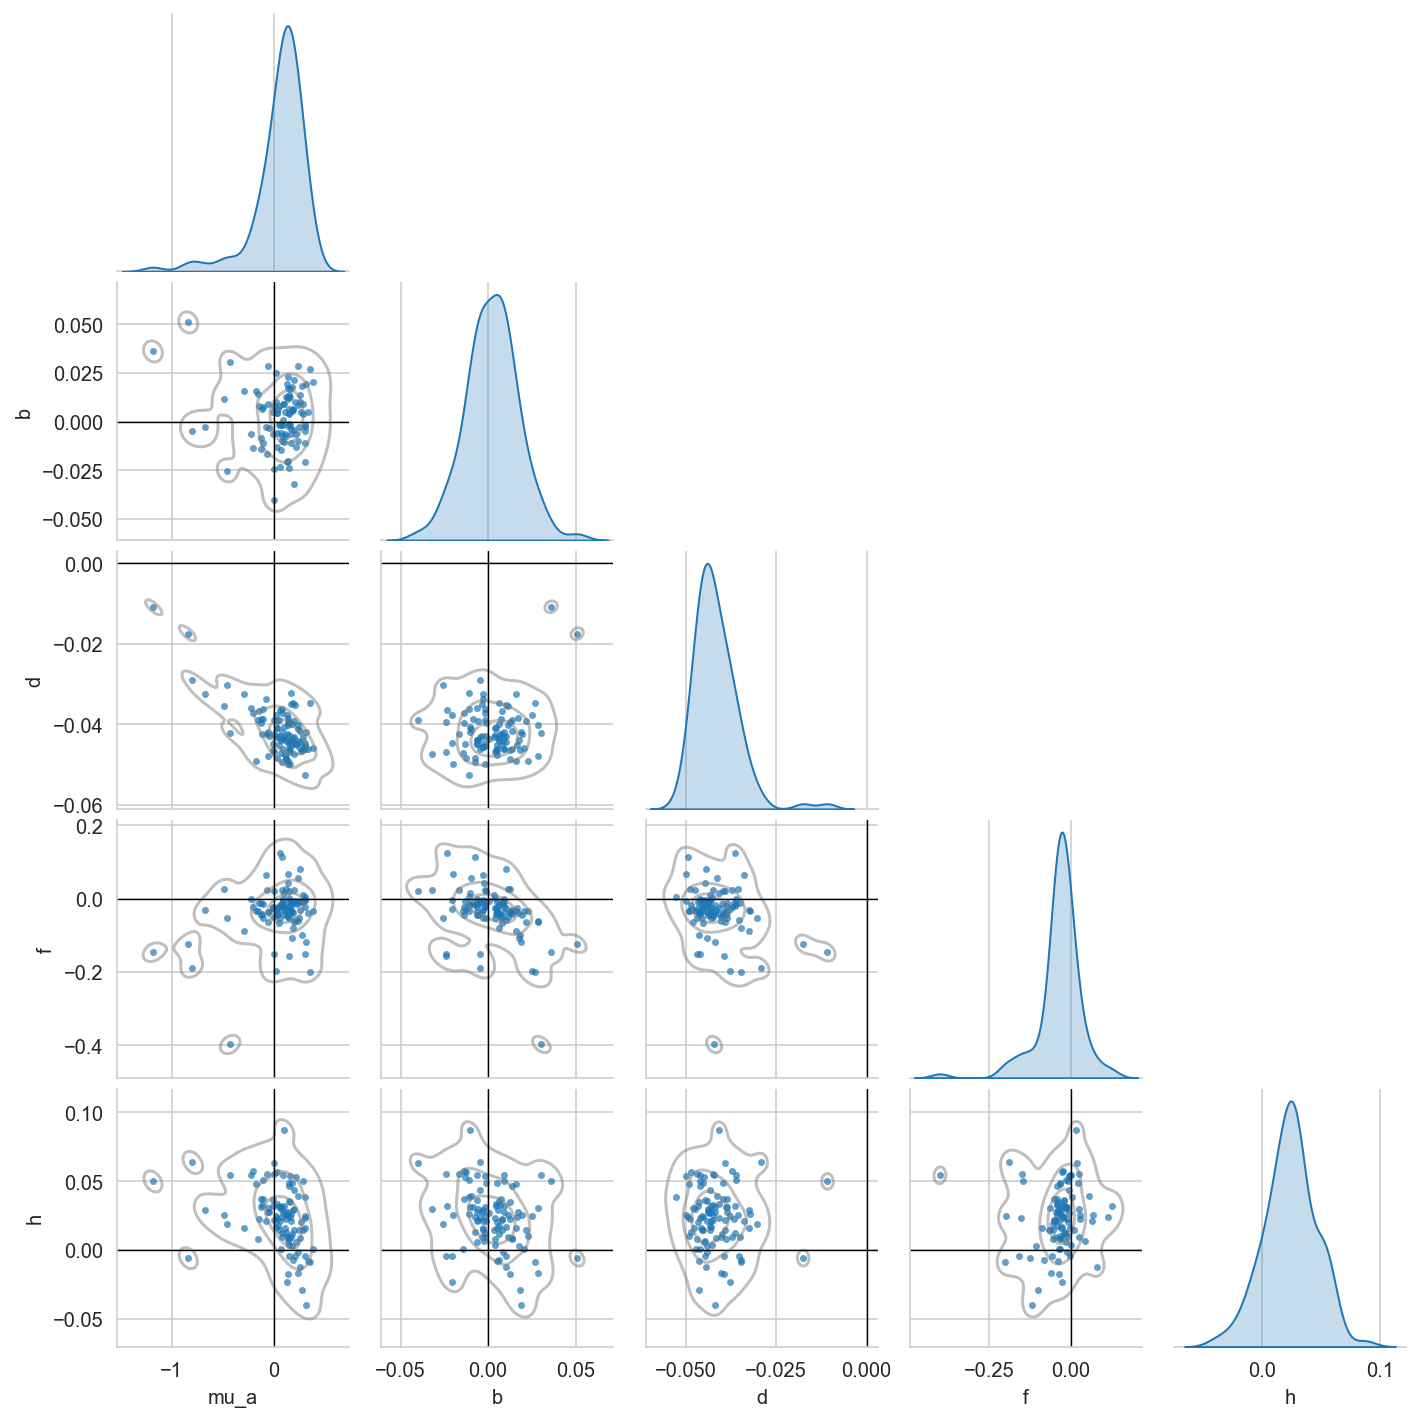

In [32]:
gene_effects = (
    trace.posterior.get(["mu_a", "b", "d", "f", "h"])
    .to_dataframe()
    .groupby(["gene"])
    .mean()
)
g = sns.pairplot(
    gene_effects,
    corner=True,
    diag_kind="kde",
    height=2,
    aspect=1,
    plot_kws={"edgecolor": None, "alpha": 0.7, "s": 10, "color": "tab:blue"},
)
g.map_lower(sns.kdeplot, levels=4, color="gray", alpha=0.5)
g.map_lower(lambda *args, **kwargs: plt.gca().axhline(color="k", linewidth=0.7))
g.map_lower(lambda *args, **kwargs: plt.gca().axvline(color="k", linewidth=0.7))
plt.show()

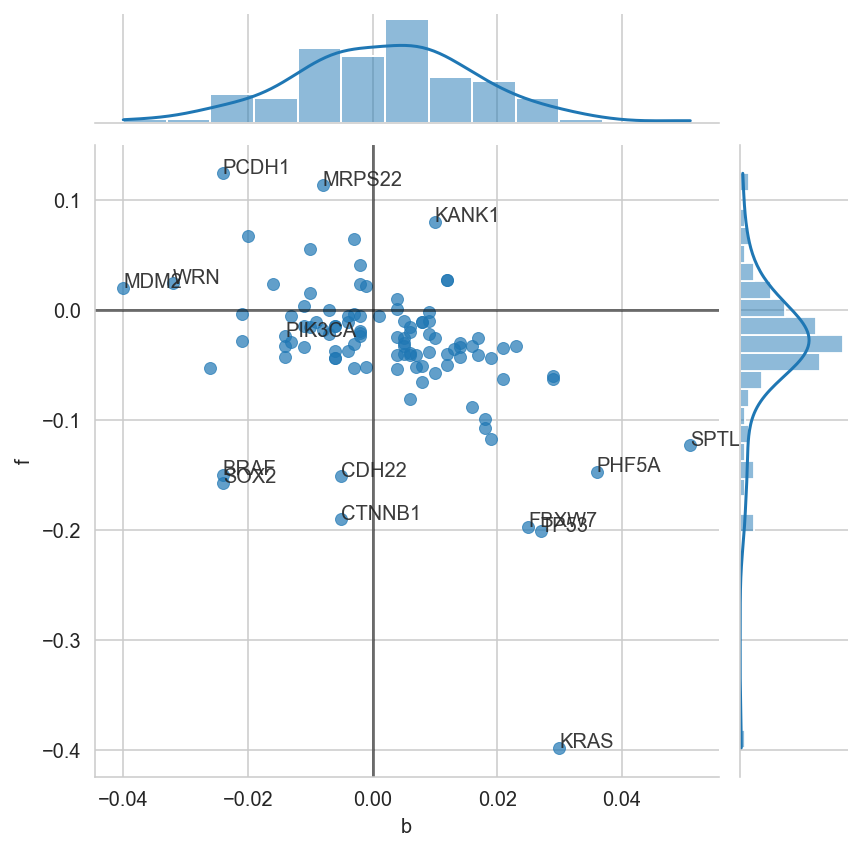

In [33]:
b_f_post = (
    az.summary(trace, var_names=["f", "b"])
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .assign(var_name=lambda d: [x[0] for x in d.index.values])
    .pivot_wider("hugo_symbol", names_from="var_name", values_from="mean")
    .set_index("hugo_symbol")
)

jp = sns.jointplot(
    data=b_f_post,
    x="b",
    y="f",
    marginal_kws={"kde": True},
    joint_kws={"edgecolor": None, "alpha": 0.7},
)
ax = jp.ax_joint
ax.axhline(0, color="k", alpha=0.5)
ax.axvline(0, color="k", alpha=0.5)

genes_to_label = list(trace.posterior.coords["cancer_gene"].values)
genes_to_label += b_f_post[b_f_post["f"] < -0.14].index.tolist()
genes_to_label += b_f_post[b_f_post["f"] > 0.075].index.tolist()
genes_to_label += b_f_post[b_f_post["b"] < -0.03].index.tolist()
genes_to_label += b_f_post[b_f_post["b"] > 0.03].index.tolist()
genes_to_label = list(set(genes_to_label))
for gene in genes_to_label:
    data = b_f_post.query(f"hugo_symbol == '{gene}'")
    assert len(data) == 1
    ax.text(data["b"], data["f"], s=gene, alpha=0.9)


plt.show()

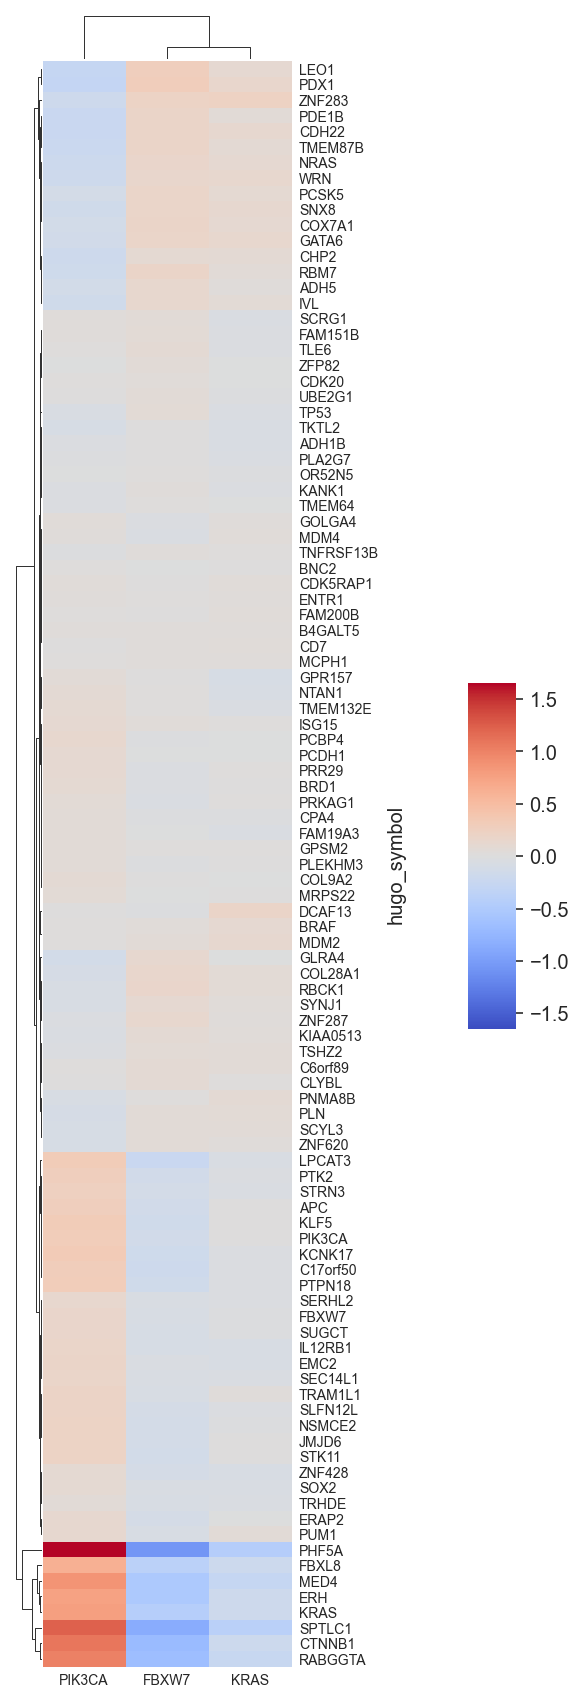

In [34]:
h_post_summary = (
    az.summary(trace, var_names="h", kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol", "cancer_gene"])
    .pivot_wider("hugo_symbol", names_from="cancer_gene", values_from="mean")
    .set_index("hugo_symbol")
)

vmax = np.abs(h_post_summary.values).max()

figsize = (3.3, 12)
dendro_ratio = (0.1, figsize[0] * 0.1 / figsize[1])
cm = sns.clustermap(
    h_post_summary,
    z_score=None,
    cmap="coolwarm",
    vmin=-vmax,
    vmax=vmax,
    figsize=figsize,
    dendrogram_ratio=dendro_ratio,
    cbar_pos=(1, 0.4, 0.1, 0.2),
    yticklabels=1,
)
cm.ax_heatmap.tick_params("both", labelsize=7, size=0)
plt.show()

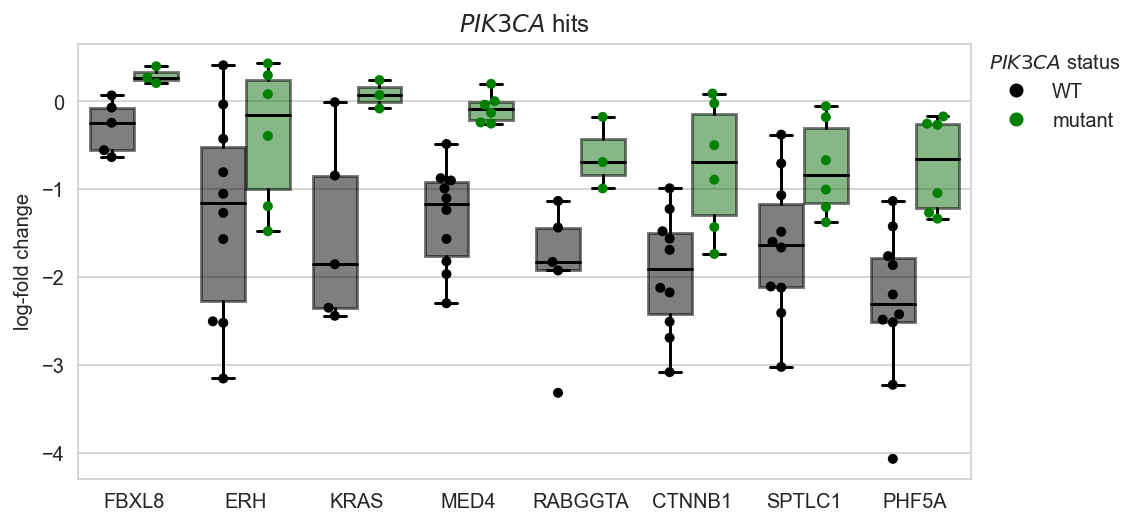

In [35]:
pik3ca_hits = h_post_summary.sort_values("PIK3CA").query("PIK3CA > 0.5").index.tolist()

pik3ca_mut_map = (
    crc_data.copy()
    .query("hugo_symbol == 'PIK3CA'")[["depmap_id", "is_mutated"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={"is_mutated": "pik3ca_mut"})
)

pik3ca_hits_data = (
    crc_data.copy()
    .filter_column_isin("hugo_symbol", pik3ca_hits)
    .merge(pik3ca_mut_map, on="depmap_id")
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d["hugo_symbol"], categories=pik3ca_hits, ordered=True
        )
    )
)

pal = {
    False: "k",
    True: "g",
}

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    data=pik3ca_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="pik3ca_mut",
    palette=pal,
    dodge=True,
    ax=ax,
    flierprops={"markersize": 0},
    boxprops={"alpha": 0.5},
)
sns.swarmplot(
    data=pik3ca_hits_data,
    x="hugo_symbol",
    y="lfc",
    hue="pik3ca_mut",
    dodge=True,
    ax=ax,
    palette=pal,
)

ax.set_title("$\mathit{PIK3CA}$ hits")
ax.set_xlabel(None)
ax.set_ylabel("log-fold change")
ax.get_legend().remove()

leg_lbl = {True: "mutant", False: "WT"}
leg_handles = [
    Line2D([0], [0], linewidth=0, marker="o", color=v, label=leg_lbl[k])
    for k, v in pal.items()
]
ax.legend(
    handles=leg_handles,
    loc="upper left",
    bbox_to_anchor=(1, 1.02),
    title="$\mathit{PIK3CA}$ status",
    frameon=False,
)

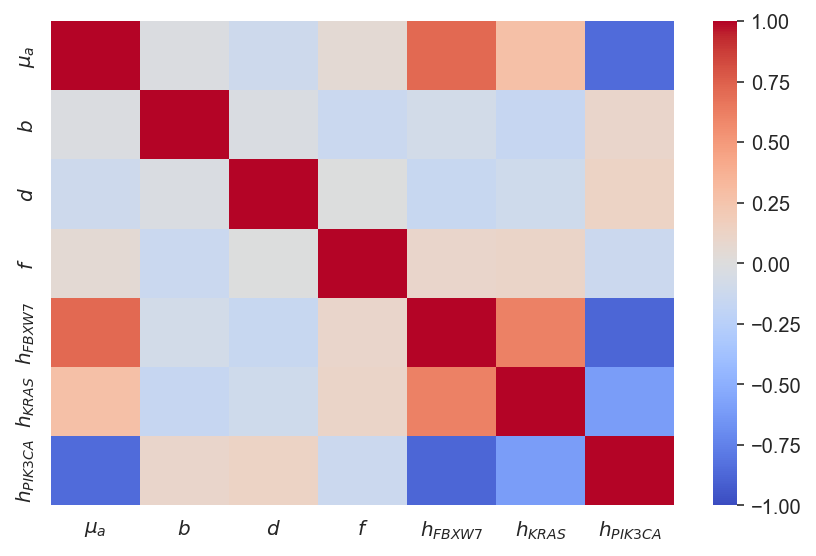

In [36]:
gene_vars = ["$\mu_a$", "$b$", "$d$", "$f$"]
gene_vars += ["$h_{" + g + "}$" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, var_names=["genes_chol_cov_corr"], kind="stats")
    .pipe(extract_coords_param_names, names=["d0", "d1"])
    .astype({"d0": int, "d1": int})
    .assign(
        p0=lambda d: [gene_vars[i] for i in d["d0"]],
        p1=lambda d: [gene_vars[i] for i in d["d1"]],
    )
)

plot_df = gene_corr_post.pivot_wider(
    "p0", names_from="p1", values_from="mean"
).set_index("p0")
ax = sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

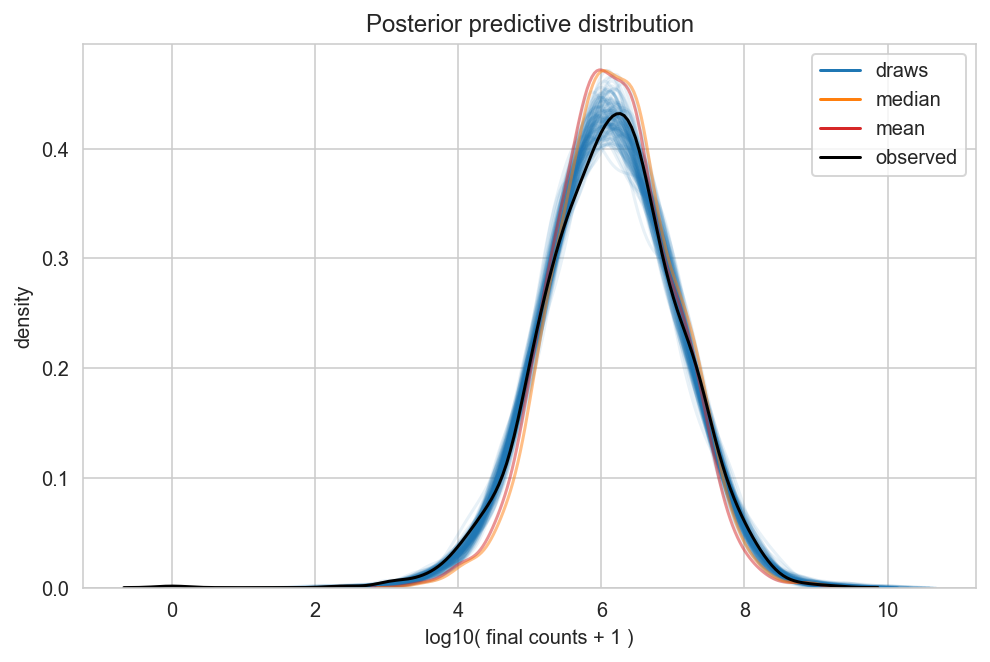

In [37]:
N = 100

pp_dist = trace.posterior_predictive["ct_final"]
n_chains, n_draws, n_samples = pp_dist.shape
draws_idx = np.random.choice(np.arange(n_draws), N // n_chains, replace=False)

fig, ax = plt.subplots(figsize=(8, 5))

ppc_pal = {
    "draws": "tab:blue",
    "median": "tab:orange",
    "mean": "tab:red",
    "observed": "black",
}

# Example draws.
for c, d in product(range(n_chains), draws_idx):
    values = np.log(pp_dist[c, d, :].values + 1)
    sns.kdeplot(values, color=ppc_pal["draws"], alpha=0.1, ax=ax)

# Average distributions.
pp_dist_mean = np.log(pp_dist.median(axis=(0, 1)) + 1)
pp_dist_mid = np.log(pp_dist.mean(axis=(0, 1)) + 1)
sns.kdeplot(pp_dist_mean, color=ppc_pal["mean"], ax=ax, alpha=0.5)
sns.kdeplot(pp_dist_mid, color=ppc_pal["median"], ax=ax, alpha=0.5)

# Observed distribution.
sns.kdeplot(
    np.log(trace.observed_data["ct_final"] + 1), ax=ax, color=ppc_pal["observed"]
)


ppc_leg_handles: list[Line2D] = []
for lbl, c in ppc_pal.items():
    ppc_leg_handles.append(Line2D([0], [0], color=c, label=lbl))

plt.legend(handles=ppc_leg_handles, loc="best")


ax.set_xlabel("log10( final counts + 1 )")
ax.set_ylabel("density")
ax.set_title("Posterior predictive distribution")
plt.show()

In [ ]:
# az.plot_forest(trace, var_names=["b", "f"], combined=True)
# plt.show()

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m